## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Loading Dataset

In [2]:
df = pd.read_csv('Energy_Production.csv', index_col=0, parse_dates=True)
df.head()

,IPG2211A2N
DATE,
1992-01-01,85.5560
1992-02-01,80.4178
1992-03-01,74.7390
1992-04-01,69.8367
1992-05-01,67.3781


In [3]:
len(df)

325

In [4]:
df.isnull().sum()

IPG2211A2N    0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 325 entries, 1992-01-01 to 2019-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   IPG2211A2N  325 non-null    float64
dtypes: float64(1)
memory usage: 5.1 KB


## Exploratory Data Analysis

Text(0.5, 1.0, 'Industrial Production for Electricity and Gas Utilities')

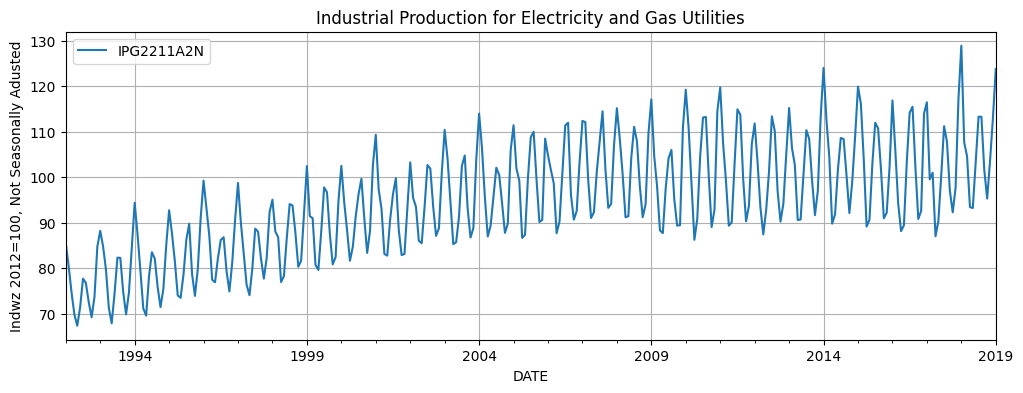

In [6]:
df.plot(figsize=(12,4))
plt.grid(True)
plt.plot(df['IPG2211A2N'])
plt.ylabel("Indwz 2012=100, Not Seasonally Adusted")
plt.title("Industrial Production for Electricity and Gas Utilities")

## Changing the Data Type into Float

In [7]:
y = df['IPG2211A2N'].values.astype(float)
y

array([ 85.556 ,  80.4178,  74.739 ,  69.8367,  67.3781,  71.4197,
        77.7263,  76.7791,  72.5681,  69.2363,  73.7175,  84.7818,
        88.2287,  84.7919,  79.6885,  71.2731,  67.9111,  74.5503,
        82.3366,  82.2906,  74.8323,  69.8758,  74.6278,  84.4669,
        94.4017,  87.4053,  79.4751,  71.1817,  69.5934,  78.1988,
        83.5287,  82.1321,  75.9181,  71.4802,  75.4754,  85.0772,
        92.7412,  87.667 ,  81.5205,  74.0457,  73.5003,  78.5503,
        86.2425,  89.8063,  78.7442,  73.9353,  79.8903,  91.0933,
        99.2688,  93.1691,  87.2075,  77.4715,  76.9337,  82.1958,
        86.2321,  86.824 ,  79.4425,  74.911 ,  81.3   ,  90.753 ,
        98.7482,  90.0486,  83.2671,  76.3793,  74.0777,  80.0138,
        88.7168,  88.0487,  82.1801,  77.7266,  82.2802,  92.3623,
        95.0701,  88.0838,  86.8125,  76.9828,  78.2652,  86.7123,
        94.1078,  93.7954,  87.7915,  80.3296,  81.6742,  91.9551,
       102.4467,  91.4671,  91.0236,  80.7497,  79.6373,  88.1

## Setting Training and Test Set Size

In [8]:
test_size = 12

In [9]:
train_set = y[:-test_size]
test_set = y[-test_size:]

In [10]:
test_set

array([107.6711, 104.5716,  93.4491,  93.2405, 103.3083, 113.3178,
       113.2758, 101.5656,  95.3203, 103.575 , 112.9498, 123.7687])

In [11]:
len(train_set)

313

In [12]:
len(test_set)

12

## Normalization

In [13]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [14]:
train_normalized = scaler.fit_transform(train_set.reshape(-1,1))

In [15]:
train_normalized.min()

-1.0

In [16]:
train_normalized.max()

1.0000000000000004

In [17]:
train_normalized.mean()

-0.12206174942208882

In [18]:
type(train_normalized)

numpy.ndarray

In [19]:
train_set[0]

85.556

In [20]:
train_normalized[0]

array([-0.4091274])

## Converting to Tensor

In [21]:
train_normalized = torch.FloatTensor(train_normalized).view(-1)

## Preparaing Training Sequences

In [22]:
def input_data(sequence, window_size):
    output = []    # List of tuples
    length_of_sequence = len(sequence)

    for i in range(length_of_sequence - window_size):
        window = sequence[i: i + window_size]
        label = sequence[i + window_size: i + window_size + 1]
        output.append((window, label))

    return output

In [23]:
window_size = 12

train_data = input_data(
    sequence=train_normalized,
    window_size=window_size
)

In [24]:
len(train_data)

301

In [25]:
train_data[0]

(tensor([-0.4091, -0.5761, -0.7607, -0.9201, -1.0000, -0.8686, -0.6636, -0.6944,
         -0.8313, -0.9396, -0.7939, -0.4343]),
 tensor([-0.3223]))

## Creating LSTM Model

In [26]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden = (
            torch.zeros(1,1,hidden_size), 
            torch.zeros(1,1,hidden_size)
        )

    def forward(self, sequence):
        lstm_out, self.hidden = self.lstm(
            sequence.view(len(sequence), 1, -1),
            self.hidden
        )
        prediction = self.linear(lstm_out.view(len(sequence), -1))
        return prediction[-1]

In [27]:
model = LSTM()
model

LSTM(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [28]:
parameter_list = []
for param in model.parameters():
    parameter_list.append(param.numel())

print(f"Total Number of Parameters: {sum(parameter_list)}")

Total Number of Parameters: 17217


## Training the Model

In [29]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [30]:
epochs = 50

In [31]:
start_time = time.time()

for epoch in range(epochs):
    for sequence, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (
            torch.zeros(1,1,model.hidden_size), 
            torch.zeros(1,1,model.hidden_size)
        )

        y_pred = model(sequence)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch+1} Loss: {loss.item()}")

total_time = time.time() - start_time
print(f"Total Time: {total_time / 60}")

Epoch: 1 Loss: 0.7296932935714722
Epoch: 2 Loss: 0.2482442855834961
Epoch: 3 Loss: 0.2710953950881958
Epoch: 4 Loss: 0.2548694610595703
Epoch: 5 Loss: 0.24254363775253296
Epoch: 6 Loss: 0.23244047164916992
Epoch: 7 Loss: 0.22401653230190277
Epoch: 8 Loss: 0.2167140543460846
Epoch: 9 Loss: 0.21001075208187103
Epoch: 10 Loss: 0.20357026159763336
Epoch: 11 Loss: 0.19718407094478607
Epoch: 12 Loss: 0.1907145380973816
Epoch: 13 Loss: 0.1840641349554062
Epoch: 14 Loss: 0.17716503143310547
Epoch: 15 Loss: 0.16998794674873352
Epoch: 16 Loss: 0.16256532073020935
Epoch: 17 Loss: 0.15502049028873444
Epoch: 18 Loss: 0.1475716084241867
Epoch: 19 Loss: 0.14049029350280762
Epoch: 20 Loss: 0.1340276002883911
Epoch: 21 Loss: 0.12834952771663666
Epoch: 22 Loss: 0.12351460754871368
Epoch: 23 Loss: 0.11949305236339569
Epoch: 24 Loss: 0.1162005364894867
Epoch: 25 Loss: 0.11353317648172379
Epoch: 26 Loss: 0.11138854920864105
Epoch: 27 Loss: 0.10967867821455002
Epoch: 28 Loss: 0.10833216458559036
Epoch: 29 L

## Invert the normalization

In [32]:
future_forecast = 12

In [33]:
preds = train_normalized[-window_size:].tolist()

model.eval()

for forecast in range(future_forecast):
    sequence = torch.FloatTensor(preds[-window_size:])

    with torch.no_grad():
        model.hidden = (
            torch.zeros(1,1,model.hidden_size), 
            torch.zeros(1,1,model.hidden_size)
        )

        preds.append(model(sequence).item())

In [34]:
preds[window_size:]

[0.317926287651062,
 -0.014569234102964401,
 -0.34511253237724304,
 -0.23681262135505676,
 0.1886308193206787,
 0.44205737113952637,
 0.3021787405014038,
 -0.08004257827997208,
 -0.27422425150871277,
 -0.04321511462330818,
 0.5089542269706726,
 0.6454654335975647]

In [35]:
true_predictions = scaler.inverse_transform(
    np.array(preds[window_size:]).reshape(-1,1)
)

true_predictions

array([[107.92344328],
       [ 97.6943848 ],
       [ 87.5253855 ],
       [ 90.85717811],
       [103.94573284],
       [111.74227399],
       [107.43897786],
       [ 95.6801301 ],
       [ 89.70622801],
       [ 96.81310861],
       [113.80032232],
       [118.00002133]])

In [36]:
df['IPG2211A2N'][-12:]

DATE
2018-02-01    107.6711
2018-03-01    104.5716
2018-04-01     93.4491
2018-05-01     93.2405
2018-06-01    103.3083
2018-07-01    113.3178
2018-08-01    113.2758
2018-09-01    101.5656
2018-10-01     95.3203
2018-11-01    103.5750
2018-12-01    112.9498
2019-01-01    123.7687
Name: IPG2211A2N, dtype: float64

## Plot the Results

In [37]:
x = np.arange('2018-02-01', '2019-02-01', dtype="datetime64[M]")
x

array(['2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
       '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01'],
      dtype='datetime64[M]')

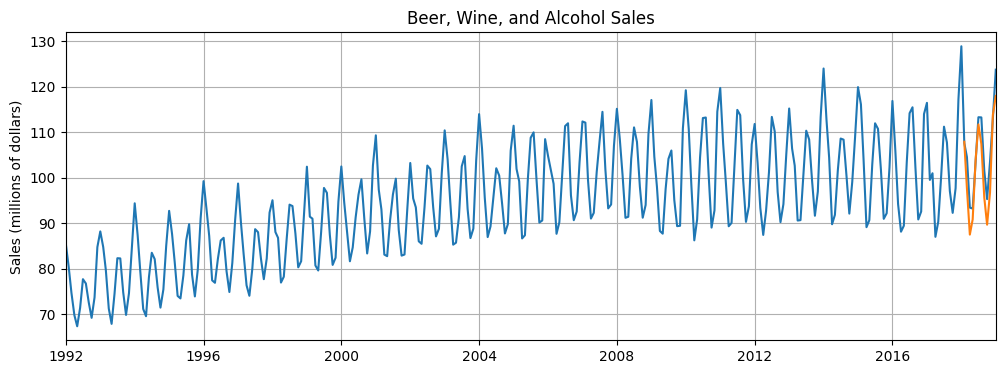

In [38]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x,true_predictions)
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)');

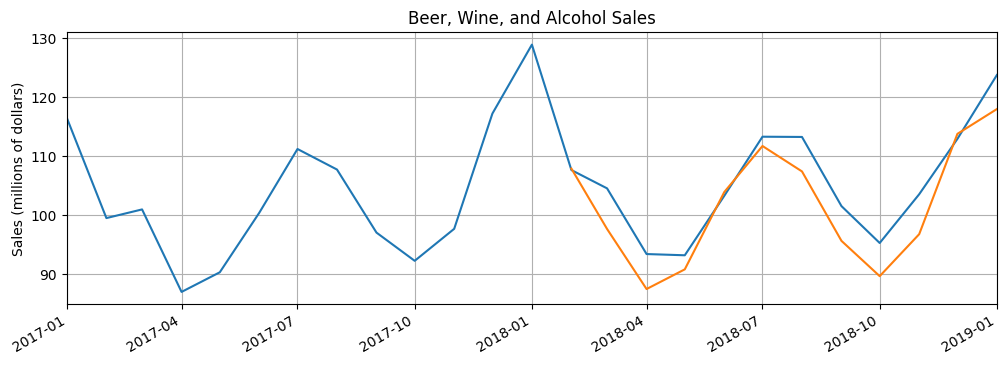

In [39]:
fig = plt.figure(figsize=(12,4))
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['IPG2211A2N']['2017-01-01':])
plt.plot(x,true_predictions)
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)');

## Forecast into an unknown future

In [40]:
epochs = 50

In [41]:
# set model to back to training mode
model.train()

LSTM(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [42]:
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

In [43]:
start_time = time.time()

for epoch in range(epochs):
    for sequence, y_train in all_data:
        optimizer.zero_grad()
        model.hidden = (
            torch.zeros(1,1,model.hidden_size), 
            torch.zeros(1,1,model.hidden_size)
        )

        y_pred = model(sequence)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch} Loss: {loss.item()}")

total_time = time.time() - start_time
print(f"Total Time: {total_time / 60}")

Epoch: 0 Loss: 0.0007999550434760749
Epoch: 1 Loss: 0.0014185721520334482
Epoch: 2 Loss: 0.0016585250850766897
Epoch: 3 Loss: 0.001978525659069419
Epoch: 4 Loss: 0.0023731915280222893
Epoch: 5 Loss: 0.0028274001087993383
Epoch: 6 Loss: 0.003325938479974866
Epoch: 7 Loss: 0.0038585562724620104
Epoch: 8 Loss: 0.004418660886585712
Epoch: 9 Loss: 0.005001118406653404
Epoch: 10 Loss: 0.005600447300821543
Epoch: 11 Loss: 0.006209255661815405
Epoch: 12 Loss: 0.006817079149186611
Epoch: 13 Loss: 0.007409512531012297
Epoch: 14 Loss: 0.007967770099639893
Epoch: 15 Loss: 0.008468136191368103
Epoch: 16 Loss: 0.00888205599039793
Epoch: 17 Loss: 0.009175455197691917
Epoch: 18 Loss: 0.009309208951890469
Epoch: 19 Loss: 0.009242515079677105
Epoch: 20 Loss: 0.008943898603320122
Epoch: 21 Loss: 0.008416459895670414
Epoch: 22 Loss: 0.007730273995548487
Epoch: 23 Loss: 0.007001639809459448
Epoch: 24 Loss: 0.006257906090468168
Epoch: 25 Loss: 0.005384011194109917
Epoch: 26 Loss: 0.00429866649210453
Epoch: 

## Predict Future Values

In [44]:
window_size = 12
future_forecast = 12

In [45]:
preds = y[-window_size:].tolist()

for forecast in range(future_forecast):
    sequence = torch.FloatTensor(preds[-window_size:])

    with torch.no_grad():
        model.hidden = (
            torch.zeros(1,1,model.hidden_size), 
            torch.zeros(1,1,model.hidden_size)
        )

        preds.append(model(sequence).item())

In [46]:
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

In [47]:
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

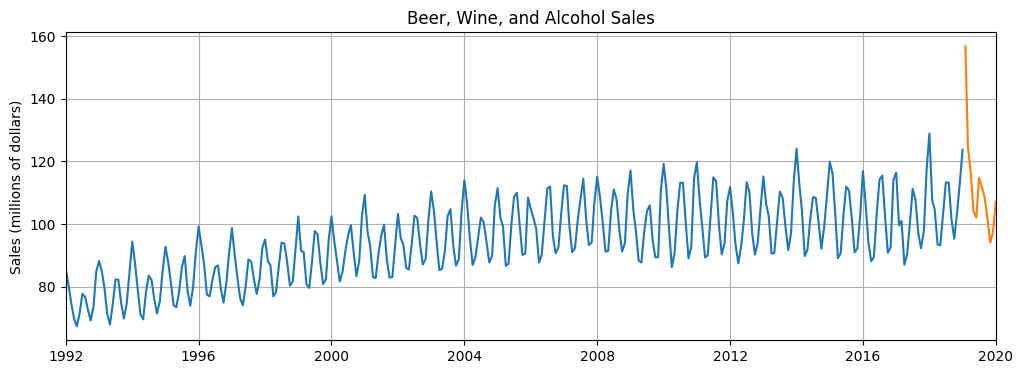

In [48]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x,true_predictions[window_size:])
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)');

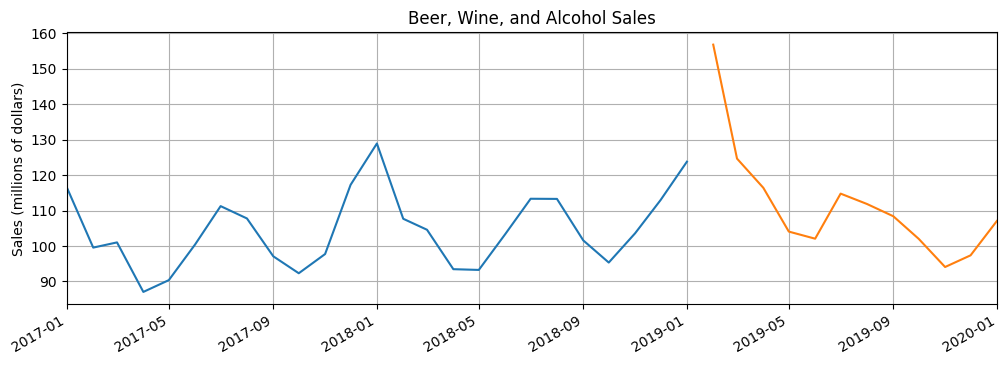

In [49]:
fig = plt.figure(figsize=(12,4))
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['IPG2211A2N']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)');